In [257]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
import csv
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sn
import statistics
from scipy import stats

data.csv includes lastest edition FIFA 2019 players attributes like Age, Nationality, Overall, Club,              
Wage, Preferred_Foot, Position, Height, Weight, ShortPassing, FKAccuracy, LongPassing, BallControl, Acceleration, SprintSpeed, Agility, Reactions, Balance, ShotPower, Jumping, Stamina, Strength, LongShots, Positioning, Penalties.  

Возраст, Национальность, Общий, Клуб, Заработная плата, Предпочтительная нога,
        Положение, рост, вес, шортпассинг, точность FK,
        Long Passing, контроль мяча, ускорение, скорость спринта, ловкость,
        Реакции, баланс, сила удара, прыжки, выносливость, сила,
        Длинные выстрелы, Позиционирование, Пенальти

In [262]:
master_data=pd.read_csv('data.csv')
master_data.head()
master_data.drop(columns = ['Unnamed: 0','Name','ID','WorkRate','BodyType','RealFace','LoanedFrom','Value','InternationalReputation','Joined','WeakFoot','GKDiving', 'GKHandling','GKKicking', 'GKPositioning','Aggression','Vision','Vision','Special', 'SkillMoves','Volleys', 'Dribbling', 'Curve','Interceptions', 'HeadingAccuracy','Crossing', 'Potential','Finishing', 'GKReflexes', 'ReleaseClause','ContractValidUntil','JerseyNumber','Flag','ClubLogo','LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB','Photo','Composure', 'Marking', 'StandingTackle', 'SlidingTackle'], inplace=True)
master_data.columns.str.strip()
master_data.rename(columns = {'PreferredFoot':'Preferred_Foot'                              
                             }, inplace = True)
master_data.fillna(master_data.mean(), inplace=True)
# 

Подготовка данных, убираем NaN значения, переводим единицы измерения к русским и обрабатываем категориальные признаки

In [263]:
master_data['Wage'] = master_data.Wage.str.replace('€','')
master_data['Wage'] = master_data.Wage.str.replace('K','000')
master_data['Wage'] = master_data.Wage.astype('int64')
master_data['Weight'] = master_data.Weight.str.replace('lbs','').astype('float64')
master_data['Height'] = master_data.Height.str.replace('\'','.').astype('float64')
master_data.fillna(0, inplace=True)

In [265]:
master_data['Preferred_Foot'] = master_data.Preferred_Foot.astype('category')
master_data['Nationality'] = master_data.Nationality.astype('category')
master_data['Club'] = master_data.Club.astype('category')
master_data['Position'] = master_data.Position.astype('category')
master_data['Weight'] = master_data.Weight*0.454
master_data['Height'] = master_data.Height*30

In [266]:
master_data.head().T

,0,1,2,3,4
Age,31,33,26,27,27
Nationality,Argentina,Portugal,Brazil,Spain,Belgium
Overall,94,94,92,91,91
Club,FCBarcelona,Juventus,ParisSaint-Germain,ManchesterUnited,ManchesterCity
Wage,565000,405000,290000,260000,355000
Preferred_Foot,Left,Right,Right,Right,Right
Position,RF,ST,LW,GK,RCM
Height,5130,5580,5310,5760,4599
Weight,32.7724,37.7192,30.9174,34.6275,31.7419
ShortPassing,90,81,84,50,92


point 2

In [267]:
cols = ['Mean', 'Mode', 'Median', 'Variance', 'Skew', 'Kurtosis', 'Range', 'Std', 'k variation']
temp= []
dt_stat = pd.DataFrame(columns=cols)
pre_dt = 0
for name, values in master_data.iteritems():
    if (master_data[name].dtype.name != 'category'):
#         temp.append(name)
        temp.append(statistics.mean(master_data[name]))
        temp.append(statistics.mode(master_data[name]))
        temp.append(statistics.median(master_data[name]))
        temp.append(statistics.variance(master_data[name]))
        temp.append(stats.skew(master_data[name]))
        temp.append(stats.kurtosis(master_data[name]))
        temp.append(np.max(master_data[name])-np.min(master_data[name]))
        temp.append(np.std(master_data[name]))
        temp.append(np.std(master_data[name])/statistics.mean(master_data[name])*100)  
        dt_stat.loc[name] = temp
        temp=[]
        pre_dt = pre_dt+1
print(dt_stat)
# plt.figure(figsize=(8, 12))
# sn.heatmap(dt_stat['Mean'].values, annot=True)
# master_data.columns
        

                     Mean        Mode      Median      Variance      Skew  \
Age             25.122206    21.00000    25.00000  2.180836e+01  0.391732   
Overall         66.238699    66.00000    66.00000  4.773331e+01  0.067179   
Wage          9731.312133  1000.00000  3000.00000  4.839688e+08  7.905368   
Height        5203.874938  5400.00000  5310.00000  2.338956e+05 -3.541539   
Weight          34.120762    34.00914    34.00914  1.338039e+01 -1.936397   
ShortPassing    58.686712    64.00000    62.00000  2.155055e+02 -1.101678   
FKAccuracy      42.863153    42.00000    41.00000  3.047017e+02  0.102244   
LongPassing     52.711933    62.00000    56.00000  2.343242e+02 -0.596378   
BallControl     58.369459    65.00000    63.00000  2.777084e+02 -1.269433   
Acceleration    64.614076    69.00000    67.00000  2.222511e+02 -0.816311   
SprintSpeed     64.726967    68.00000    67.00000  2.140553e+02 -0.829612   
Agility         63.503607    68.00000    66.00000  2.174614e+02 -0.600158   

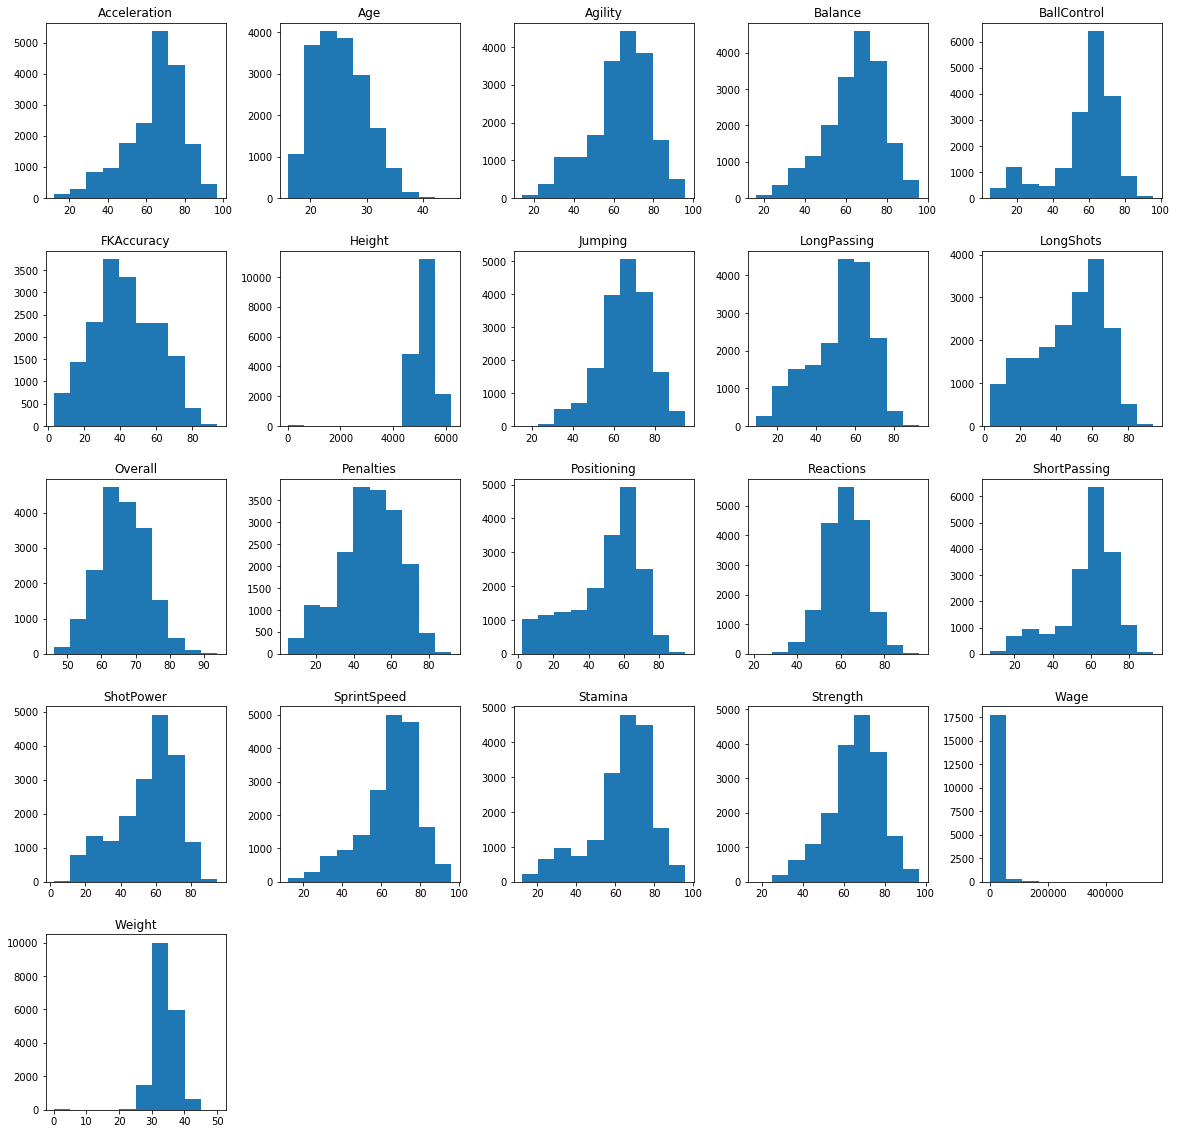

In [268]:
# Print histograms for each feature to see how they vary
histohrams = master_data.hist(grid=False, figsize=(20, 20))

point 3

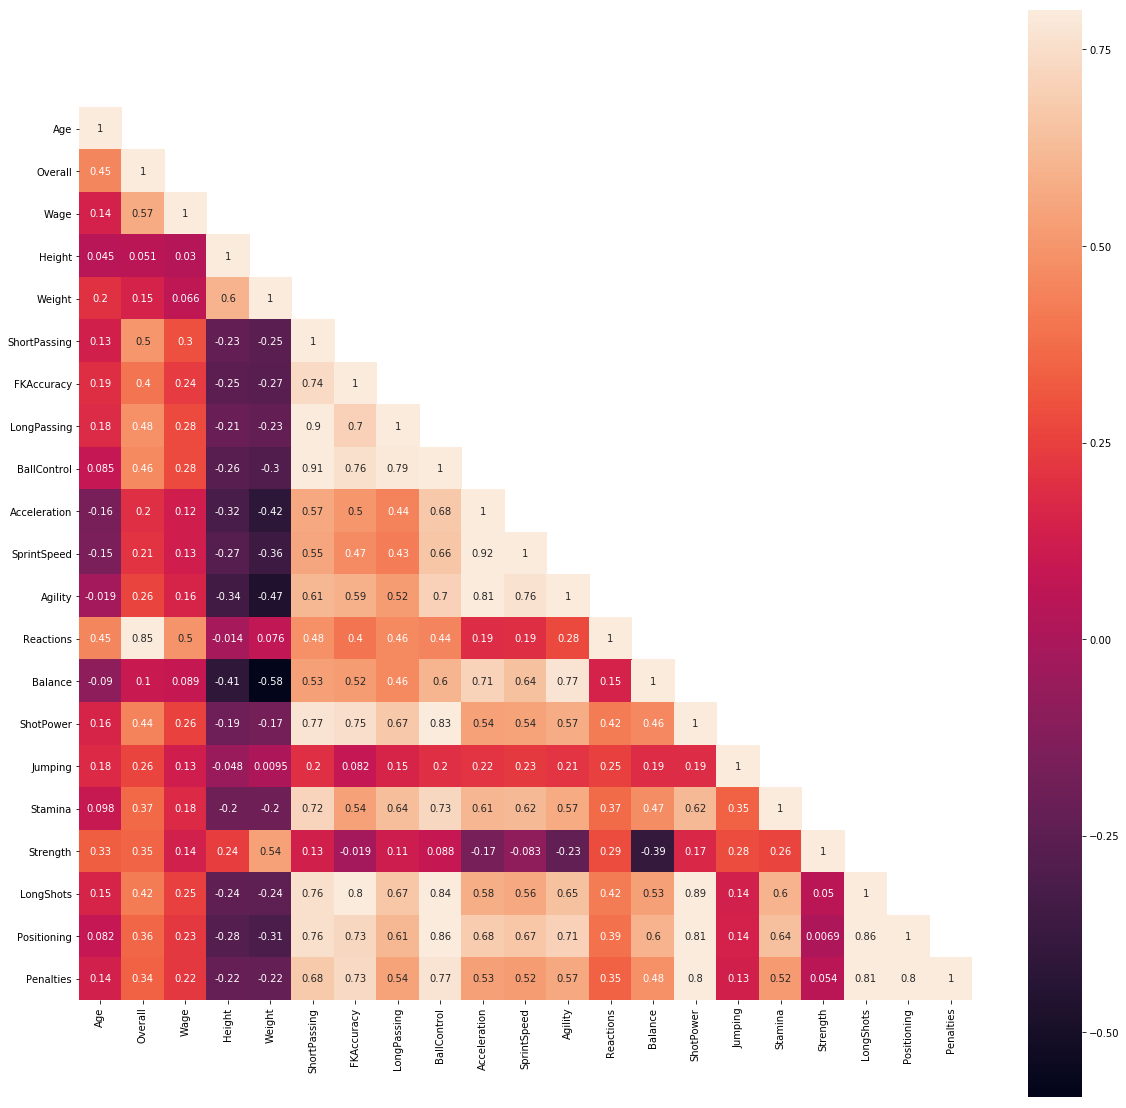

In [269]:
corr = master_data.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(20,20)
sn.heatmap(corr, mask=mask, vmax=.8, square=True, annot = True)

point 4

Training data set will be used for training of our linear model. Testing dataset will be used for validating of the model. All data from testing dataset will be new to model and we may check how accurate are model predictions.

In [270]:
X = master_data.drop(['Overall',
                     'Nationality',
                      'Club',
                      'Preferred_Foot',
                      'Position'], axis=1)
Y = master_data['Overall']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

Коэффициенты регрессии

In [271]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, Y_train)
cdf = pd.DataFrame(lin_reg.coef_,X.columns, columns=['Coefficients'])
print(cdf)
print("Independent term in the model "+ str(lin_reg.intercept_))

              Coefficients
Age               0.149775
Wage              0.000058
Height            0.000449
Weight            0.118400
ShortPassing      0.037894
FKAccuracy        0.005664
LongPassing       0.015506
BallControl       0.049849
Acceleration      0.020785
SprintSpeed       0.023317
Agility           0.025041
Reactions         0.475307
Balance          -0.038964
ShotPower         0.022017
Jumping           0.012513
Stamina          -0.026903
Strength          0.021950
LongShots         0.012469
Positioning      -0.056223
Penalties        -0.018339
Independent term in the model 19.33276600259579


In [272]:
Y_pred = lin_reg.predict(X_test)
print('Prediction:', Y_pred)
# средне квадратическая ошибка
mse = mean_squared_error(Y_test, Y_pred)
print('mean_squared_error : ',mse)

Prediction: [75.89270459 68.25345163 57.16458602 ... 68.14695978 63.11732852
 72.59569924]
mean_squared_error :  9.773557895746698


In [273]:
alfa = 0.05
n = Y_pred.size-1
t = stats.t(n)
tcr = t.ppf(1-alfa/2)
print ("среднее: ", Y_pred)
print ("<queue_mean>", np.mean(Y_pred), "</queue_mean>")
print ("<queue_di>", tcr*np.std(Y_pred)/np.sqrt(Y_pred.size), "</queue_di>")

среднее:  [75.89270459 68.25345163 57.16458602 ... 68.14695978 63.11732852
 72.59569924]
<queue_mean> 66.28747991138054 </queue_mean>
<queue_di> 0.14078715793506938 </queue_di>


In [274]:
#R^2 (coefficient of determination) regression score function.
r2 = r2_score(Y_test, Y_pred)
print('r2 score from scipy: ',r2)
r2_adj = 1-((1-r2*r2)*(Y_pred.size-1)/(Y_pred.size-1-len(X_test.columns)))
print('r2_adj', r2_adj)

r2 score from scipy:  0.7930259435155488
r2_adj 0.627868087455261


In [275]:
X2 = sm.add_constant(X_train)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     2167.
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:57:48   Log-Likelihood:                -27890.
No. Observations:               10924   AIC:                         5.582e+04
Df Residuals:                   10903   BIC:                         5.597e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           19.3328      0.582     33.203   

In [277]:
abs(est2.tvalues) > tcr

const            True
Age              True
Wage             True
Height           True
Weight           True
ShortPassing     True
FKAccuracy      False
LongPassing      True
BallControl      True
Acceleration     True
SprintSpeed      True
Agility          True
Reactions        True
Balance          True
ShotPower        True
Jumping          True
Stamina          True
Strength         True
LongShots        True
Positioning      True
Penalties        True
dtype: bool

Незначимы: FKAccuracy, LongPassing, Jumping

In [278]:
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

const           382.541618
Age               1.580413
Wage              1.366175
Height            1.564009
Weight            2.484956
ShortPassing     12.259899
FKAccuracy        3.782775
LongPassing       6.206683
BallControl      12.033104
Acceleration      8.835595
SprintSpeed       7.317212
Agility           4.557043
Reactions         2.076202
Balance           3.564149
ShotPower         6.192460
Jumping           1.364222
Stamina           3.029599
Strength          2.637762
LongShots         7.871212
Positioning       6.456343
Penalties         3.916688
dtype: float64

Получается так. Часто используют границу 5 или 10, если показатель VIF больше данного значения - есть линейная зависимость от остальных переменных

In [279]:
col = ['Wage']
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.32398041748847384


In [280]:
col.append('Age')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.4642980075579102


In [281]:
col.append('Reactions')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7643356236149644


In [283]:
col.append('Balance')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.764434750930771


In [284]:
col.append('Height')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7666832951717623


In [285]:
col.append('Weight')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7696056090592169


In [286]:
col.append('BallControl')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7854961845259942


In [287]:
col.append('Positioning')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7893895172808139


In [288]:
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     5119.
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:58:42   Log-Likelihood:                -28140.
No. Observations:               10924   AIC:                         5.630e+04
Df Residuals:                   10915   BIC:                         5.636e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          21.3090      0.576     37.001      

In [289]:
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

const          357.877442
Wage             1.351951
Age              1.341589
Reactions        1.956506
Balance          2.281665
Height           1.540859
Weight           2.051814
BallControl      4.460234
Positioning      4.074060
dtype: float64

In [290]:
np.linalg.cond(est2.model.exog)

455845.54474251176

In [291]:
np.abs(est2.params/np.std(Y_train)*np.std(X_train[col])).sort_values(ascending = False)

Reactions      0.640065
BallControl    0.276047
Wage           0.188653
Positioning    0.126214
Age            0.100791
Weight         0.075194
Balance        0.036141
Height         0.026179
const               NaN
dtype: float64

In [292]:
np.abs(est2.params/np.mean(Y_train)*np.mean(X_train[col])).sort_values(ascending = False)

Reactions      0.457256
BallControl    0.101906
Weight         0.074773
Age            0.056662
Positioning    0.034123
Height         0.030139
Balance        0.017199
Wage           0.008677
const               NaN
dtype: float64

In [293]:
np.mean(lin_reg.predict(X_train) - Y_train)

1.0169008724710185e-14

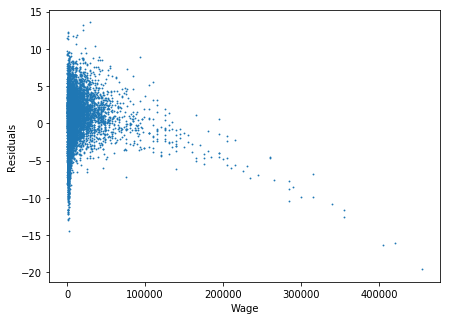

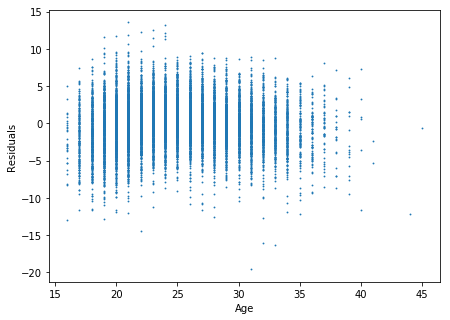

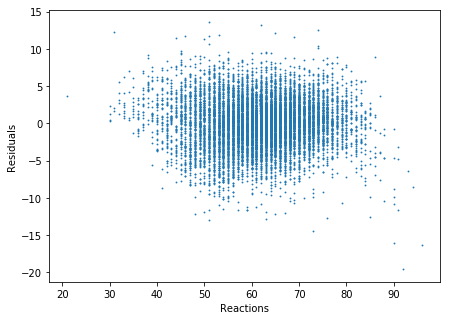

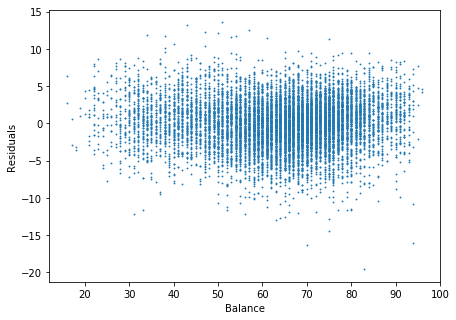

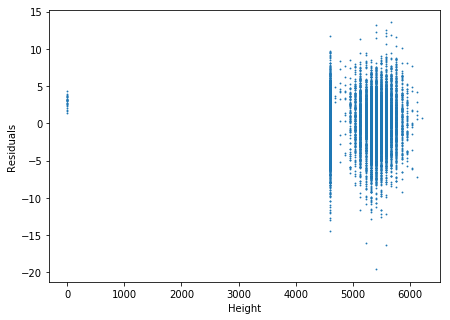

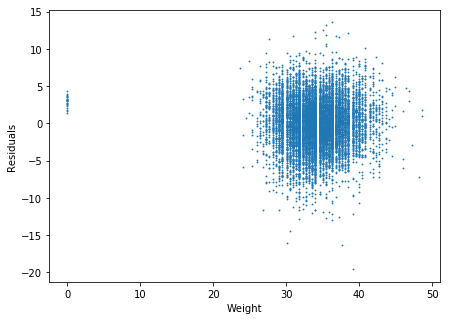

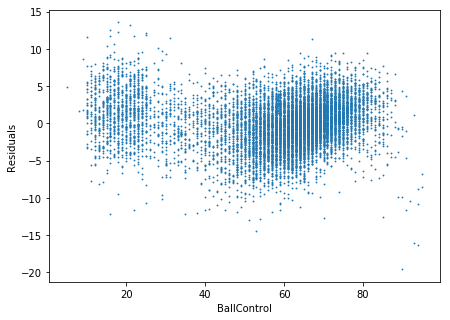

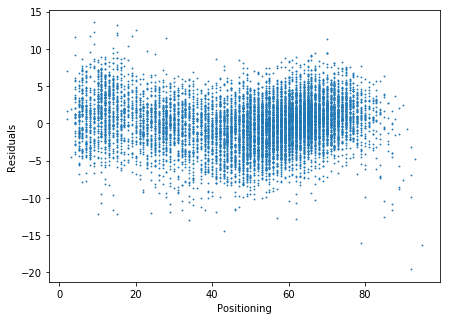

In [294]:
for i, j in enumerate(col):
    plt.figure(figsize=(7,5))
    plt.scatter(X_train[j], est2.resid, s=0.7)
    plt.xlabel(j)
    plt.ylabel('Residuals')

plt.show()


In [295]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(est2.resid, est2.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 796.0077142393163),
 ('p-value', 1.492482699510026e-166),
 ('f-value', 107.23280532531493),
 ('f p-value', 5.0074989086492316e-173)]

In [296]:
durbin_watson(est2.resid)

2.006628300042474

~2, следовательно, нет автокорреляциии